# Lesson 2 - Ensembling

## Lesson Video:

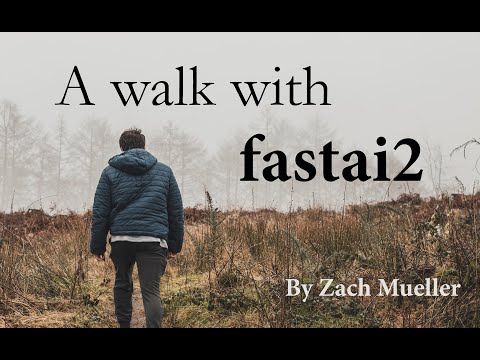

In [ ]:
#hide_input
from IPython.lib.display import YouTubeVideo
from datetime import timedelta
start = int(timedelta(minutes=36, seconds=38).total_seconds())
YouTubeVideo('-aCtDIgbxMw', start=start)

In [ ]:
#hide
#Run once per session
!pip install fastai wwf rfpimp -q --upgrade

In [ ]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf', 'xgboost', 'sklearn', 'rfpimp'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, `wwf`, `xgboost`, `sklearn`, and `rfpimp` currently running at the time of writing this:
* `fastai`: 2.1.10 
* `fastcore`: 1.3.13 
* `wwf`: 0.0.8 
* `xgboost`: 0.90 
* `sklearn`: 0.0 
* `rfpimp`: 1.3.6 
---

Often for tabular problems, we deal with ensembling from other models. For today, we'll look at using XGBoost (Gradient Boosting) mixed in with `fastai`, and you'll notice we'll be using `fastai` to prepare our data!

In [ ]:
from fastai.tabular.all import *

Let's first build our `TabularPandas` object:

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()
splits = RandomSplitter()(range_of(df))

In [ ]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

## XGBoost

* Gradient Boosting
* [Documentation](https://xgboost.readthedocs.io/en/latest/)

In [ ]:
import xgboost as xgb

We'll need our `x`'s and our `y`'s

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
model = xgb.XGBClassifier(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)

And now we can fit our classifier:

In [ ]:
xgb_model = model.fit(X_train, y_train)

And we'll grab the raw probabilities from our test data:

In [ ]:
xgb_preds = xgb_model.predict_proba(X_test)

In [ ]:
xgb_preds

array([[0.89155704, 0.10844298],
       [0.6882768 , 0.31172317],
       [0.79331285, 0.20668715],
       ...,
       [0.49610275, 0.50389725],
       [0.90957344, 0.09042657],
       [0.9879613 , 0.01203871]], dtype=float32)

And check it's accuracy

In [ ]:
accuracy(tensor(xgb_preds), tensor(y_test))

tensor(0.8340)

We can even plot the importance

In [ ]:
from xgboost import plot_importance

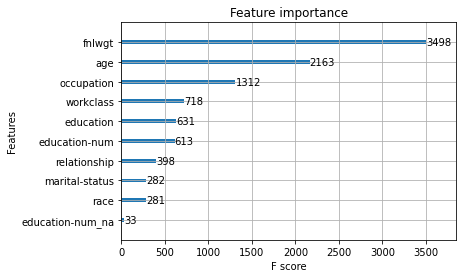

In [ ]:
plot_importance(xgb_model)

## Bring in `fastai`

In [ ]:
dls = to.dataloaders()

In [ ]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)

In [ ]:
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.378514,0.372543,0.829545,00:04
1,0.363559,0.371811,0.827242,00:04
2,0.356018,0.362737,0.830313,00:04
3,0.359589,0.359365,0.836609,00:04
4,0.343187,0.362838,0.838452,00:04


As we can see, our neural network has 83.84%, slighlty higher than the GBT

Now we'll grab predictions

In [ ]:
nn_preds = learn.get_preds()[0]

In [ ]:
nn_preds

tensor([[0.9685, 0.0315],
        [0.6587, 0.3413],
        [0.5426, 0.4574],
        ...,
        [0.3229, 0.6771],
        [0.9517, 0.0483],
        [0.9978, 0.0022]])

Let's check to see if our feature importance changed at all

In [ ]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df if df is not None else None
    bs = bs if bs is not None else learn.dls.bs
    self.dl = learn.dls.test_dl(self.df, bs=bs) if self.df is not None else learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

Getting base error


Calculating Permutation Importance


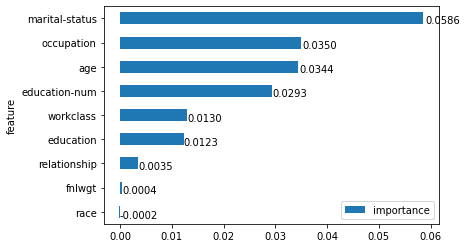

In [ ]:
imp = PermutationImportance(learn)

And it did! Is that bad? No, it's actually what we want. If they utilized the same things, we'd expect very similar results. We're bringing in other models to hope that they can provide a different outlook to how they're utilizing the features (hopefully differently)

## Ensembling

And perform our ensembling! To do so we'll average our predictions to gather (take the sum and divide by 2)

In [ ]:
avgs = (nn_preds + xgb_preds) / 2

In [ ]:
avgs

tensor([[0.9300, 0.0700],
        [0.6735, 0.3265],
        [0.6679, 0.3321],
        ...,
        [0.4095, 0.5905],
        [0.9307, 0.0693],
        [0.9929, 0.0071]])

And now we'll take the argmax to get our predictions:

In [ ]:
argmax = avgs.argmax(dim=1)

In [ ]:
argmax

tensor([0, 0, 0,  ..., 1, 0, 0])

How do we know if it worked? Let's grade our predictions:

In [ ]:
y_test

array([0, 0, 0, ..., 0, 1, 0], dtype=int8)

In [ ]:
accuracy(tensor(nn_preds), tensor(y_test))

tensor(0.8385)

In [ ]:
accuracy(tensor(xgb_preds), tensor(y_test))

tensor(0.8340)

In [ ]:
accuracy(tensor(avgs), tensor(y_test))

tensor(0.8391)

As you can see we scored a bit higher!

## Bringing in Random Forests

Let's also try with Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
tree = RandomForestClassifier(n_estimators=100)

Now let's fit

In [ ]:
tree.fit(X_train, y_train);

Now, we are not going to use the default importances. Why? Read up here:

[Beware Default Random Forest Importances](https://explained.ai/rf-importance/) by Terence Parr, Kerem Turgutlu, Christopher Csiszar, and Jeremy Howard

Instead, based on their recommendations we'll be utilizing their `rfpimp` package

In [ ]:
from rfpimp import *

In [ ]:
imp = importances(tree, X_test, to.valid.ys)

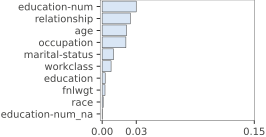

In [ ]:
plot_importances(imp)

Which as we can see, was also very different.

Now we can get our raw probabilities:

In [ ]:
forest_preds = tree.predict_proba(X_test)

In [ ]:
forest_preds

array([[0.99, 0.01],
       [0.72, 0.28],
       [0.75, 0.25],
       ...,
       [0.42, 0.58],
       [0.72, 0.28],
       [1.  , 0.  ]])

And now we can add it to our ensemble:

In [ ]:
avgs = (nn_preds + xgb_preds + forest_preds) / 3

In [ ]:
accuracy(tensor(avgs), tensor(y_test))

tensor(0.8354)

As we can see, it didn't quite work how we wanted to. But that is okay, the goal was to experiment!